In [15]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from scipy.stats import poisson
from tqdm.notebook import tqdm
%matplotlib inline

In [16]:
import tensorflow as tf

In [17]:
import random

In [18]:
# Define drift and diffusion terms of stochastic process

def drift(x,kappa,theta):
    
    return kappa*(theta-x)


def diff(x,sigma):
    
    return sigma
    

In [19]:
# Function for Compound Poisson process for the jump term 

def normal_generator(mu_jump, sigma_jump, num_events):
    return np.random.normal(mu_jump, sigma_jump, num_events)

def compound_poisson_process(rate, dt, mu_jump, sigma_jump):
    num_events = np.random.poisson(rate*dt, size = 1)
    jumps = normal_generator(mu_jump = mu_jump, sigma_jump = sigma_jump, num_events = num_events)
    
    jump = jumps.sum()

    if len(jumps) == 0:
        jump = 0
        
    return jump

#mu_jump = 0.0
#sigma_jump = 1.0
#num_events_simulated = 50

#x = compound_poisson_process(10, 0.1, mu_jump, sigma_jump)
#plt.title("Sample Compound Poisson Process (Binomial)")
#plt.xlabel("time")
#plt.ylabel("events")
#plt.legend()

In [20]:
# Function to generate the evolution of a CTMC with given initial state, and parameters (not used explicitly - only neede
# if one wants to simulate/test the volatility process)

def sv_sim(ksi, theta_vol, omega, y_0, n_sim, dt):
    
    T = 1.  # Total time.
    n = int(T / dt)  # Number of time steps.
    t = np.linspace(0., T, n)  # Vector of times.
    y = np.zeros(n)
    y[0] = y_0
    y_origin = y
    y_list = list()
    ruin_count = 0
    
    for j in tqdm(range(n_sim)):
        
        for i in range(n - 1):
                        
            #jump = compound_poisson_process(rate, dt, mu_jump, sigma_jump)
            
            y[i+1] = y[i] + drift(y[i], kappa = theta_vol, theta = omega)*dt + diff(y[i], sigma = ksi)*np.sqrt(y[i])*np.sqrt(dt)*np.random.randn()

            if y[i+1] < 0.0:
                print("negative")
                y[i+1] = 0.0
                
        plt.plot(t, y.copy(), lw=1)
        
        y_list.append(y.copy())
        
        y = y_origin
        
    plt.show()
    
    return y_list

   

In [21]:
# Function for finite-horizon path simulation of jump regime switching OU process, with a given stopping value

def ou_jump_sv_sim_stopping(kappa, theta, ksi, theta_vol, omega, mu_jump, sigma_jump, rate, dt, x_0, y_0, n_sim, stopping, T):
    
    #T = 1.  # Total time.
    n = int(T / dt)  # Number of time steps.
    t = np.linspace(0., T, n)  # Vector of times.
    x = np.zeros(n)
    y = np.zeros(n)
        
    if len(x) == 0.0:
        ruin_prob = 0.0 if x_0 <= stopping else 1.0 
        return [x_0], [y_0], ruin_prob
    
    x[0] = x_0
    y[0] = y_0
    x_origin = x
    y_origin = y
    x_list = list()
    y_list = list()
    ruin_count = 0
    
    for j in range(n_sim):
        
        if n-1 == 0:
            stopping_factor = 0.0 if ((isinstance(stopping, float)) and (x[0] <= stopping)) else 1.0
        else:

            for i in range(n - 1):

                stopping_factor = 0.0 if ((isinstance(stopping, float)) and (x[i] <= stopping)) else 1.0

                jump = compound_poisson_process(rate, dt, mu_jump, sigma_jump)

                #y[i+1] = y[i] + drift(y[i], kappa = theta_vol, theta = omega)*dt + diff(y[i], sigma = ksi)*np.sqrt(y[i])*np.sqrt(dt)*np.random.randn()
                y[i+1] = y[i] + drift(y[i], kappa = theta_vol, theta = omega)*dt + (1.0/4.0)*diff(y[i], sigma = (ksi**2))*((np.sqrt(dt)*np.random.randn())**2 - dt)

                x[i + 1] = x[i] + stopping_factor*(drift(x[i], kappa=kappa, theta=theta)*dt + diff(x[i], sigma = np.sqrt(y[i+1]))*np.sqrt(dt)*np.random.randn() \
                                + jump)


        #plt.plot(t, x.copy(), lw=1)
        
        x_list.append(x.copy())
        y_list.append(y.copy())
        
        x = x_origin
        y = y_origin
        
        if stopping_factor == 0.0:
                ruin_count += 1
        
        stopping_factor = 1.0
        
    ruin_prob = ruin_count / n_sim    
    #plt.show()
    
    return x_list, y_list, ruin_prob

   

In [1]:
# prob_list_ex = []

# for start in tqdm(np.linspace(0.0, 5.0, 51)):

#     sigma = 0.5
#     kappa = 0.3
#     theta = 0.7
#     ksi = 1.0
#     theta_vol = 0.5
#     x_0 = start
#     omega = 0.7
#     mu_jump = 0.0
#     sigma_jump = 0.5
#     rate = 1.0
#     dt = 0.0001
#     y_0 = 1.0

#     ou, vol, prob = ou_jump_sv_sim_stopping(kappa, theta, ksi, theta_vol, omega, mu_jump,
#                                        sigma_jump, rate, dt, x_0, y_0, n_sim, stopping)
    
#     prob_list_ex.append(prob)
    

#     print(prob)

In [2]:
#np.save('prob_ex_list_sv.npy', np.array(prob_list_ex))

In [3]:
#plt.plot(np.linspace(0.0, 5.0, 51), prob_list_ex)

# Neural network ruin probability estimations - Levy Jump OU 

In [22]:
# Payoff function for default with 1 if the process has defaulted and 0 else

def g_func(path, stopping):
    
    #T = 1.  # Total time.
    #n = int(T / dt)  # Number of time steps.
    #t = np.linspace(0., T, n)
    
    #path, ruin = ou_sim_2(kappa, theta, sigma, dt, x_0, 1, stopping)
    
    #g = tf.constant(1.0) if (tf.math.reduce_any(path <= 0)) else tf.constant(0.0)
    g = tf.constant(1.0) if (np.any(np.array(path) <= 0)) else tf.constant(0.0)
    return g
    

In [23]:
# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

# Set constants
kappa = 2.0
theta = 2.0
ksi = 0.07
theta_vol = 0.05
omega = 0.1
mu_jump = 0.3
sigma_jump = 0.5
rate = 1.0
dt = 0.0001

# Set boundary values for asset and volatility processes and convert to tensorflow
xmin = -5.0
xmax = 75.0
ymin = 0.0
ymax = 50.0

lb_x = tf.constant([xmin], dtype=DTYPE)
lb_y = tf.constant([ymin], dtype=DTYPE)

ub_x = tf.constant([xmax], dtype=DTYPE)
ub_y = tf.constant([ymax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(100)

# Set number of path simulations
N_sim = 50000

# Draw random initial positions, maturity times, and initial regimes for path simulations
X_0_data = tf.random.uniform((N_sim,1), lb_x, ub_x, dtype=DTYPE)
t_data = tf.random.uniform((N_sim,1), 0.0, 1.0, dtype = DTYPE)
Y_0_data = tf.random.uniform((N_sim,1), lb_y, ub_y, dtype=DTYPE)

# Concatenate all parameters that will constitute model input into tensorflow format
process_data = tf.concat([X_0_data, t_data, Y_0_data], axis=1)

# Simulate path for each (x, rho, t) and append paths in list that will be used for training
path_data_list = []

for i in tqdm(range(len(X_0_data))):
    
    path_data, vol_data, ruin =  ou_jump_sv_sim_stopping(kappa = kappa, theta = theta, ksi = ksi, theta_vol = theta_vol, 
                                               omega = omega, mu_jump = mu_jump, sigma_jump = sigma_jump, 
                                               rate = rate, dt = dt, x_0 = X_0_data[i], y_0 = Y_0_data[i], n_sim = 1, stopping = 0.0,  T = t_data[i])
    
    
    path_data_list.append(path_data.copy())
    
## Make the paths a tensor for compatability with the NN architecture    
#path_data_list = tf.stack(path_data_not_tf)   

  0%|          | 0/50000 [00:00<?, ?it/s]

In [4]:
#np.save('path_data_list_sv_y_input.npy', np.array(path_data_list))

In [7]:
#path_data_list = np.load('path_data_list_sv_y_input.npy', allow_pickle = True)

In [8]:
# Neural network parameters
num_hidden_layers = 5
num_neurons_per_layer = 10 #7 

# Initializing the feedforwad neural network
model_jump = tf.keras.Sequential()

# Input is one-dimensional (only space & fixed time)
model_jump.add(tf.keras.Input(3))

# # Scaling layer to map input to [lb, ub]
# scaling_layer = tf.keras.layers.Lambda(lambda x:
#                                       2.0*(x-lb)/(ub-lb)-1.0)
# model_jump.add(scaling_layer)

# Append hidden layers 
for _ in range(num_hidden_layers):
        model_jump.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('softplus'),
            kernel_initializer='glorot_uniform'))
        
# Output is one-dimensional
model_jump.add(tf.keras.layers.Dense(1))

In [9]:
# Compute loss functon

def loss_function(model_jump, process_data, path_data_list):
    
    loss = 0.0
    
    for i in range(len(process_data)):
        
        path_values = path_data_list[i]
        
        g = g_func(path = path_values, stopping = 0.0)
        #print(g)
        pred = model_jump(process_data[i:(i+1)])
        #print(pred)
        loss += tf.square(g - pred)
    
    loss_value = loss / len(process_data)
    
    return loss_value    
    

In [10]:
# Function that computes the gradient of the loss function

def grad(model_jump, process_data, path_data_list):
    
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model_jump.trainable_variables)
        loss_value = loss_function(model_jump, process_data, path_data_list)
    
    grad = tape.gradient(loss_value, model_jump.trainable_variables)
        
    del tape
    
    return loss_value, grad

In [11]:
# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([2000,4000,6000],[1e-1,1e-2,1e-3,1e-4])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

In [12]:
from time import time

# Training step is a TensorFlow function (increases speed of training)
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = grad(model_jump, process_data, path_data_list)
    
    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model_jump.trainable_variables))
    
    return loss

In [29]:
# Number of training epochs
N = 10000
hist = []

# Start timer
t0 = time()

for i in tqdm(range(N+1)):
    
    loss = train_step()
    
    # Append current loss to hist
    hist.append(loss.numpy())
    
    # Output current loss after 50 iterates
    if i%100 == 0:
        print('It{}: loss = {}'.format(i,loss))
        
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

  0%|          | 0/10001 [00:00<?, ?it/s]

It0: loss = [[2365.9072]]
It100: loss = [[0.13623455]]
It200: loss = [[0.05168543]]
It300: loss = [[0.03916367]]
It400: loss = [[0.03397529]]
It500: loss = [[0.03096572]]
It600: loss = [[0.02875857]]
It700: loss = [[0.02696842]]
It800: loss = [[0.02616866]]
It900: loss = [[0.02588898]]
It1000: loss = [[0.02573052]]
It1100: loss = [[0.02560684]]
It1200: loss = [[0.02549705]]
It1300: loss = [[0.02539585]]
It1400: loss = [[0.02530145]]
It1500: loss = [[0.02521322]]
It1600: loss = [[0.02513129]]
It1700: loss = [[0.0250558]]
It1800: loss = [[0.02498683]]
It1900: loss = [[0.02492447]]
It2000: loss = [[0.02486856]]
It2100: loss = [[0.02486276]]
It2200: loss = [[0.0248572]]
It2300: loss = [[0.02485142]]
It2400: loss = [[0.02484548]]
It2500: loss = [[0.02483926]]
It2600: loss = [[0.02483288]]
It2700: loss = [[0.02482626]]
It2800: loss = [[0.0248194]]
It2900: loss = [[0.02481248]]
It3000: loss = [[0.02480523]]
It3100: loss = [[0.02479792]]
It3200: loss = [[0.02479031]]
It3300: loss = [[0.0247825

In [5]:
#model_jump.save('NN_jump_sv_t_input_y_input_10')

In [19]:
#model_jump.save('NN_jump_sv_t_input_y_input')

INFO:tensorflow:Assets written to: NN_jump_sv_t_input_y_input\assets


In [68]:
xspace_jump = np.linspace(-5, 5, 1001)
X = np.meshgrid(xspace_jump)
T = np.meshgrid([1.0]*len(xspace_jump))
Xgrid_jump = np.vstack([X, T]).T

In [18]:
upred_jump = model_jump(tf.cast(Xgrid_jump,DTYPE))

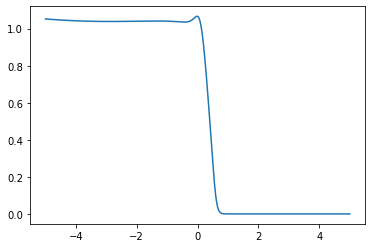

In [19]:
#upred = model_jump(tf.cast(Xgrid_jump,DTYPE))
plt.plot(xspace_jump, upred_jump)

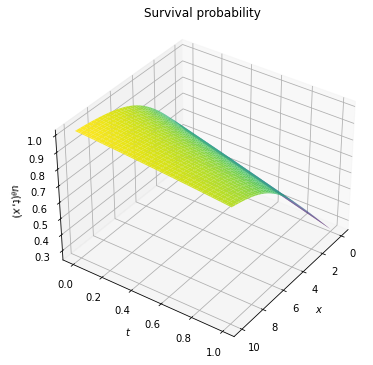

In [33]:
from mpl_toolkits.mplot3d import Axes3D

# Set up meshgrid
N = 100
tspace = np.linspace(0.0, 1.0, N + 1)
xspace = np.linspace(0, 10, N + 1)
X, T = np.meshgrid(xspace, tspace)
Xgrid = np.vstack([X.flatten(),T.flatten()]).T

Xgrid_pred = np.array([np.append(Xgrid[x],[10.0],axis=0) for x in range(len(Xgrid))])
upred = model_jump(tf.cast(Xgrid_pred,DTYPE))

# Reshape upred
U = 1-upred.numpy().reshape(N+1,N+1)

# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,T, U, cmap='viridis');
ax.view_init(35,35)
ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
ax.set_zlabel('$u_\\theta(t,x)$')
ax.set_title('Survival probability');
#plt.savefig('Burgers_Solution.pdf', bbox_inches='tight', dpi=300);

In [6]:
#model_j1 = tf.keras.models.load_model('NN_jump_sv_t_input_y_input')

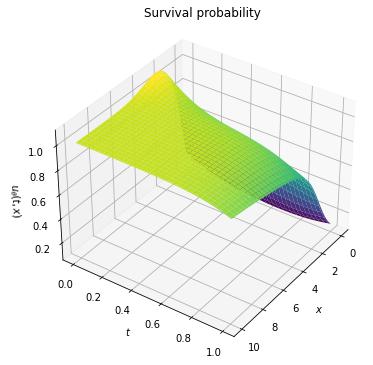

In [35]:
N = 100
tspace = np.linspace(0.0, 1.0, N + 1)
xspace = np.linspace(0, 10, N + 1)
X, T = np.meshgrid(xspace, tspace)
Xgrid = np.vstack([X.flatten(),T.flatten()]).T

Xgrid_pred = np.array([np.append(Xgrid[x],[10.0],axis=0) for x in range(len(Xgrid))])
upred = model_j1(tf.cast(Xgrid_pred,DTYPE))

# Reshape upred
U = 1-upred.numpy().reshape(N+1,N+1)

# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,T, U, cmap='viridis');
ax.view_init(35,35)
ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
ax.set_zlabel('$u_\\theta(t,x)$')
ax.set_title('Survival probability');
#plt.savefig('Burgers_Solution.pdf', bbox_inches='tight', dpi=300);

### 

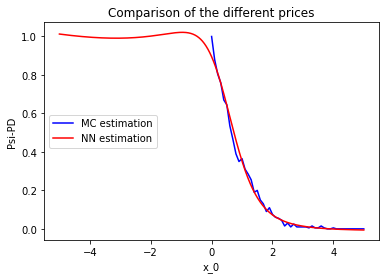

In [33]:
# Comparison with MC

x_mc = np.linspace(0.0, 5.0, 51)
mc = prob_list_ex

fig, ax = plt.subplots()
ax.plot(x_mc, mc, label='MC estimation', color='blue')
ax.plot(xspace_jump, upred_jump, label='NN estimation', color = 'red')
legend = ax.legend(loc='center left')
plt.xlabel('x_0')
plt.ylabel('Psi-PD')
plt.title('Comparison of the different prices')
plt.show()

In [7]:
# # with learning rate

# cases = [1, 2, 3, 4, 5]
# fig, ax = plt.subplots()

# for hidden in tqdm(cases):    
    
#     # Neural network parameters
#     num_hidden_layers = hidden
#     num_neurons_per_layer = 10

#     # Initializing the feedforwad neural network
#     model_jump = tf.keras.Sequential()

#     # Input is one-dimensional (only space & fixed time)
#     model_jump.add(tf.keras.Input(1))

#     # Scaling layer to map input to [lb, ub]
#     scaling_layer = tf.keras.layers.Lambda(lambda x:
#                                           2.0*(x-lb)/(ub-lb)-1.0)
#     model_jump.add(scaling_layer)

#     # Append hidden layers 
#     for _ in range(num_hidden_layers):
#             model_jump.add(tf.keras.layers.Dense(num_neurons_per_layer,
#                 activation=tf.keras.activations.get('softplus'),
#                 kernel_initializer='glorot_uniform'))

#     # Output is one-dimensional
#     model_jump.add(tf.keras.layers.Dense(1))

    
#     @tf.function
#     def train_step():
#     # Compute current loss and gradient w.r.t. parameters
#         loss, grad_theta = grad(model_jump, X_0_data, path_data_list)

#         # Perform gradient descent step
#         optim.apply_gradients(zip(grad_theta, model_jump.trainable_variables))

#         return loss



#     lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([2000,4000,6000,8000],[1e-1,1e-2,1e-3,1e-4, 1e-5])

#     # Choose the optimizer
#     optim = tf.keras.optimizers.Adam(learning_rate=lr)

#     # Number of training epochs
#     N = 3000
#     hist = []

#     # Start timer
#     t0 = time()

#     for i in tqdm(range(N+1)):

#         loss = train_step()

#         # Append current loss to hist
#         hist.append(loss.numpy())

#         # Output current loss after 50 iterates
#         if i%100 == 0:
#             print('It{}: loss = {}'.format(i,loss))

#     # Print computation time
#     print('\nComputation time: {} seconds'.format(time()-t0))
    
#     xspace_jump = np.linspace(lb, ub, 1001)
#     X = np.meshgrid(xspace_jump)
#     Xgrid_jump = np.vstack([X]).T
#     upred_jump = model_jump(tf.cast(Xgrid_jump,DTYPE))
#     ax.plot(xspace_jump, upred_jump, label=f'{hidden} hidden layers')
#     legend = ax.legend(loc='right', fontsize='x-small')
    
# plt.show()